In [1]:
import zipfile as zp
from math import ceil
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")
# from sklearn import set_config
# set_config(display='diagram')   

In [3]:
df_list = []
for file in ["train.csv", "test.csv"]:
    with zp.ZipFile("./data.zip") as myzip:
        with myzip.open(file) as myfile:
            df_list.append(pd.read_csv(myfile))
            
train_df, test_df = df_list

In [4]:
# Correcting variables
train_df.rename({"Parents or siblings infected": "Parents_Children_Infected", 
                 "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)
test_df.rename({"Parents or siblings infected": "Parents_Children_Infected", 
                "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)

In [5]:
train_df.set_index("Patient_ID", inplace=True)
test_df.set_index("Patient_ID", inplace=True)

In [6]:
X_train = train_df.drop('Deceased', axis=1)
y_train = train_df['Deceased']
X_test = test_df.copy()

# Pipeline

In [7]:
# Saving parameter grid for specific Grid Search run
class ComplexEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (StandardScaler, MinMaxScaler, OneHotEncoder, ExtraTreesClassifier, RandomForestClassifier, KNeighborsClassifier, NeighborhoodComponentsAnalysis, LogisticRegression, SelectFromModel, np.ndarray, dict)):  # Include all classes that aren't serializable here
            return str(obj)
        # Let the base class default method raise the TypeError 
        return json.JSONEncoder.default(self, obj)
    

def gs_outputs(id_num, gscv_fitted, grid):
    """
    Function that saves information of each grid-search.
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    grid: takes the grid used to fit the GridSearchCV object
    
    Returns:
    top 20 configurations hyper-parameter presence graphic
    (also outputs the "logs" of each grid-search to the output directory)
    """
    # Saving parameter grid for specific Grid Search run
    with open("./outputs/grids.txt", "a") as file:
        file.write("# {}------------------------------------------------------ #\n".format(id_num) + json.dumps(grid, cls=ComplexEncoder) + "\n\n")

    # Saving cv_results for specific Grid Search run
    score_summary = pd.DataFrame(gscv_fitted.cv_results_).sort_values(by="mean_test_score", ascending=False)
    score_summary.to_csv("./outputs/grid_search_results{}.csv".format(id_num))
    
    # Assessing distribution of hyper-parameter values amongst top 20 models
    sns.set()

    # Features to plot
    plot_features = list(map(lambda x: "param_" + x, {i for j in range(len(grid)) for i in grid[j].keys()}))
    plot_df = score_summary.reset_index(drop=True).loc[:19, :].fillna("NaN")

    # figure and axes
    fig, axes = plt.subplots(3, ceil(len(plot_features)/3), figsize=(23,13))

    # plot data
    for ax, x in zip(axes.flatten(), plot_features):
        try:
            sns.countplot(x=x, data=plot_df, ax=ax)
        except TypeError:
            sns.countplot(x=plot_df[x].apply(json.dumps), ax=ax)

    plt.suptitle("Hyper-parameter presence on top 20 models", y=0.95, fontsize=25)

    plt.savefig("./outputs/grid_results{}.png".format(id_num))
    
    # Model training - using best parameters to train model on entire data for submission
    best_model = full_pipeline.set_params(**gscv_fitted.best_params_)
    best_model.fit(X_train, y_train)  # Using all of the data to fit the model

    # Predicting the 
    y_pred = best_model.predict(test_df)

    # Submission
    pd.DataFrame(data={"Patient_ID": test_df.index.to_list(), "Deceased": y_pred}).to_csv("./outputs/submission{}.csv".format(id_num), index=False)
    
    return plt.show()


def feature_importance(id_num, gscv_fitted, fimp_pre=True):
    """
    Function that show feature importance plot and saves it to outputs folder
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    fimp_pre: whether to evaluate feature importance pre or pos model
    
    Returns:
    feature importance graphic    
    """
    if fimp_pre:
        if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"] != 'passthrough'):

            # Get feature names
            numeric_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[0][2]
            categorical_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[1][2]
            categorical_features = list(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].named_transformers_["ohe"].get_feature_names(categorical_features))
            feature_names = numeric_features + categorical_features

            # Get feature importances
            if hasattr(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_, "feature_importances_"):  # Check if features_importances_ attribute exists. Necessary when there's tree selectors
                if len(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_.shape) != 2: 
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_, index=feature_names).T
                else:
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_, index=gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.classes_, columns=feature_names)
            else:
                if len(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_.shape) != 2: 
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_, index=feature_names).T
                else:
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_, index=gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.classes_, columns=feature_names)

            colors = feature_importances.applymap(lambda x: "tab:red" if x < 0 else "tab:blue")  # Get positive and negative colors
            threshold = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].threshold_  # Get SelectFromModel threshold value 

            sns.set()
            if feature_importances.shape[0] == 3:
                fig, axes = plt.subplots(3, 1, figsize=(23,12))
                blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
                red_patch = mpatches.Patch(color='tab:red', label='Negative')
                threshold_line = mlines.Line2D([], [], linestyle="dashed", color='black', label='Threshold')

                for i, ax in enumerate(axes.flatten()):
                    ax.bar(x=feature_names, height=abs(feature_importances.iloc[i]), color=colors.iloc[i])
                    ax.hlines(threshold, -0.5, 18.5, linestyles="dashed")
                    ax.set_xticklabels(feature_names, rotation = 30, ha="right")
                    ax.set_title("Class {} Feature Importance".format(feature_importances.index[i]), fontsize=18)
                    ax.legend(handles=[blue_patch, red_patch, threshold_line], fontsize=12)

                plt.subplots_adjust(hspace=0.6)
                plt.savefig("./outputs/feature_importance{}.png".format(id_num))
                return plt.show()
            else: 
                fig = plt.figure(figsize=(23,6))
                blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
                red_patch = mpatches.Patch(color='tab:red', label='Negative')
                threshold_line = mlines.Line2D([], [], linestyle="dashed", color='black', label='Threshold')

                plt.bar(x=feature_names, height=abs(feature_importances.iloc[0]), color=colors.iloc[0])
                plt.hlines(threshold, -0.5, len(feature_names) - 0.5, linestyles="dashed")
                plt.xticks(rotation=30, ha="right")
                plt.title("Pre Feature Importance", fontsize=18)
                plt.legend(handles=[blue_patch, red_patch, threshold_line], fontsize=12)

                plt.savefig("./outputs/feature_importance_pre{}.png".format(id_num))
                return plt.show()
        else:
            print("No feature selection was done!")
    else:
        if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["dimred"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["dimred"] != 'passthrough'):
            # Obtaining Component Names
            feature_names = ["PC" + str(i) for i in range(1, best_model.named_steps["prep"].named_steps["dimred"].n_components + 1)]
        else:  
            # Get feature names
            numeric_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[0][2]
            categorical_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[1][2]
            categorical_features = list(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].named_transformers_["ohe"].get_feature_names(categorical_features))
            feature_names = numeric_features + categorical_features

            # Get filtered feature names
            if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"] != 'passthrough'):
                feature_names = np.array(feature_names)[gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].get_support()]

        # Get feature importances
        if len(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_.shape) != 2: 
            feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_, index=feature_names).T
        else:
            feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_, index=gscv_fitted.best_estimator_.named_steps["model"].classes_, columns=feature_names)
        
        colors = feature_importances.applymap(lambda x: "tab:red" if x < 0 else "tab:blue")  # Get positive and negative colors

        sns.set()
        fig = plt.figure(figsize=(23,6))
        blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
        red_patch = mpatches.Patch(color='tab:red', label='Negative')

        plt.bar(x=feature_names, height=abs(feature_importances.iloc[0]), color=colors.iloc[0])
        plt.xticks(rotation=30, ha="right")
        plt.title("Pos Feature Importance", fontsize=18)
        plt.legend(handles=[blue_patch, red_patch], fontsize=12)

        plt.savefig("./outputs/feature_importance_pos{}.png".format(id_num))
        return plt.show()
        

# def plot_tree(id_num, gscv_fitted):
#     """
#     Function that shows the decision tree graph and saves it as png
    
#     id_num: takes an id_number which identifies the grid-search
#     gscv_fitted: takes a fitted GridSearchCV object
    
#     Returns:
#     decision tree graphic
#     """
#     if (gscv_fitted.named_steps["prep"].named_steps["fselect2"]) and (gscv_fitted.named_steps["prep"].named_steps["fselect2"] != 'passthrough'):
#         # Obtaining Component Names
#         feature_names = ["PC" + str(i) for i in range(1, best_model.named_steps["prep"].named_steps["fselect2"].n_components + 1)]
#     else:  
#         # Get feature names
#         numeric_features = gscv_fitted.named_steps["prep"].named_steps["join_features"].transformers_[0][2]
#         categorical_features = gscv_fitted.named_steps["prep"].named_steps["join_features"].transformers_[1][2]
#         categorical_features = list(gscv_fitted.named_steps["prep"].named_steps["join_features"].named_transformers_["categorical_pipeline"].named_steps["one_hot_encoder"].get_feature_names(categorical_features))
#         feature_names = metric_features + categorical_features

#         # Get filtered feature names
#         if (gscv_fitted.named_steps["prep"].named_steps["fselect1"]) and (gscv_fitted.named_steps["prep"].named_steps["fselect1"] != 'passthrough'):
#             feature_names = np.array(feature_names)[gscv_fitted.named_steps["prep"].named_steps["fselect1"].get_support()]
    
#     # Set PATH variable to locate graphviz executables
#     if os.environ['PATH'].split(";")[-1] != 'C:\\Users\\davids\\Anaconda3\\envs\\ml\\Library\\bin\\graphviz':
#         os.environ['PATH'] = os.environ['PATH'] + ';' + os.environ['CONDA_PREFIX'] + r"\Library\bin\graphviz"
    
#     # Export a decision tree in DOT format
#     dot_data = export_graphviz(gscv_fitted.named_steps["model"],
#                                feature_names=feature_names,  
#                                class_names=gscv_fitted.named_steps["model"].classes_,
#                                filled=True,
#                                rounded=True)
    
#     pydot_graph = pydotplus.graph_from_dot_data(dot_data)  # load graph in dot format
#     pydot_graph.set_size('"50,50"')  # set size of graph figure
#     pydot_graph.write_png("./outputs/decision_tree{}.png".format(id_num))  # output graph as png
#     return graphviz.Source(pydot_graph.to_string())


# def effective_alpha_analysis(id_num, gscv_fitted, X_train, y_train, max_alpha, min_alpha=0):
#     """
#     Function that analyses the alphas of a decision tree and plots the cross-validated mean alpha performance of default trees.
    
#     id_num: takes an id_number which identifies the grid-search
#     gscv_fitted: takes a fitted GridSearchCV object
#     X_train: raw train data
#     y_train: train data labels
#     max_alpha: max alpha consider in cross-validation
#     min_alpha: min alpha consider in cross-validation
    
#     Returns:
#     alpha analysis graphic
#     """
#     original_model = clone(gscv_fitted.named_steps["model"])
#     analyze_model = clone(gscv_fitted.named_steps["model"].set_params(min_weight_fraction_leaf=0.0, max_depth=None))

#     # Transforming X_train based on fitted preparation pipeline
#     X_train_trans = gscv_fitted.named_steps["prep"].transform(X_train)

#     # Producing cost_complexity_pruning_path of default tree on X_train_trans
#     path = analyze_model.cost_complexity_pruning_path(X_train_trans, y_train)
#     ccp_alphas, impurities = path.ccp_alphas, path.impurities

#     # Defininf a default tree for each ccp_alpha value found
#     ccp_alphas_delim = ccp_alphas[(ccp_alphas >= min_alpha) & (ccp_alphas <= max_alpha)]
#     trees = [clone(analyze_model.set_params(ccp_alpha=ccp_alpha)) for ccp_alpha in ccp_alphas_delim]

#     # Producing 5-fold cv f1-scores for each tree on X_train_trans
#     cv_scores = np.array([cross_val_score(tree, X_train_trans, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), scoring='f1_micro', n_jobs=-1) for tree in trees])
#     cv_scores_mean, cv_scores_std = cv_scores.mean(axis=1), cv_scores.std(axis=1)
#     cv_scores_ci95 = 1.96 * cv_scores_std / cv_scores_mean
#     global_optimum = [ccp_alphas_delim[np.argmax(cv_scores_mean)], np.max(cv_scores_mean)]
#     original_cv_score = cross_val_score(original_model, X_train_trans, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), scoring='f1_micro', n_jobs=-1).mean()
    
#     sns.set()
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))

#     # Plot Total Impurity vs effective alpha for training set
#     ax1.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
#     ax1.set_xlabel("effective alpha", fontsize=14)
#     ax1.set_ylabel("total impurity of leaves", fontsize=14)
#     ax1.set_title("Total Impurity vs effective alpha for training set", fontsize=18)

#     # Plot F1-score vs alpha for cross-validation score
#     ax2.plot(ccp_alphas_delim, cv_scores_mean, marker='o', label="AVG Scores", drawstyle="steps-post")
#     ax2.plot(global_optimum[0], global_optimum[1], 'o', label="G.O.: [{0:.6f}, {1:.3f}]".format(global_optimum[0], global_optimum[1]))
#     ax2.fill_between(ccp_alphas_delim, (cv_scores_mean - cv_scores_ci95), (cv_scores_mean + cv_scores_ci95), color='b', alpha=.1)
#     ax2.hlines(original_cv_score, min_alpha, max_alpha, linestyles="dashed", label="Original Model")
#     ax2.set_xlim(left=min_alpha, right=max_alpha)
#     ax2.set_xlabel("alpha", fontsize=14)
#     ax2.set_ylabel("f1-score", fontsize=14)
#     ax2.set_title("F1-score vs alpha for cross-validation score", fontsize=18)
#     ax2.legend()
    
#     plt.savefig("./outputs/alpha_analysis{}.png".format(id_num))
#     return plt.show()

In [8]:
# This cell holds all the Custom Transformers we designed to pipeline the raw data to the model
class PrepImpute(BaseEstimator, TransformerMixin):
    """
    Creates Title
    Creates Title_binary
    Fills Medical_Tent with "NK"
    Imputes City with most frequent value
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        self.city_imputer = SimpleImputer(strategy="most_frequent")
        
    #Return self nothing else to do here
    def fit(self, X, y=None):
        self.city_imputer.fit(X[["City"]])
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X):
        
        X2 = X.copy()
        
        # CREATE NEW VARIABLES
        X2['Title'] = X2['Name'].str.split('\\W', 1, expand=True)[0]
        X2['Title_binary'] = X2['Title'].apply(lambda x: 1 if x in ["Master","Miss"] else 0)
        X2["Medical_Tent"] = X2["Medical_Tent"].fillna(value="NK")
        X2['City'] = self.city_imputer.transform(X2[["City"]])
        
        return X2 
    

class KNNImputerScaled(KNNImputer):
    """
    KNNImputer subclass that scales variables before applying imputation
    Impute Birthday_year using scaled and non-scaled variables with KNNImputer
    """
    def __init__(self, missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,
                 columns_to_norm=['Severity','Parents_Children_Infected','Partner_Siblings_Infected'], columns_not_to_norm=['Birthday_year','Title_binary'],
                 scaler=MinMaxScaler(), **scaler_args):
        super().__init__(missing_values=missing_values, 
                         n_neighbors=n_neighbors, 
                         weights=weights,
                         metric=metric,
                         copy=copy, 
                         add_indicator=add_indicator)
        self.scaler = scaler.set_params(**scaler_args)
        self.columns_to_norm = columns_to_norm
        self.columns_not_to_norm = columns_not_to_norm
        
    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X[self.columns_to_norm])
        X_trans = np.concatenate([X_scaled, X[self.columns_not_to_norm]], axis=1)
        super().fit(X_trans)
        return self
    
    def transform(self, X, y=None):
        X_scaled = self.scaler.transform(X[self.columns_to_norm])
        X_trans = np.concatenate([X_scaled, X[self.columns_not_to_norm]], axis=1)
        X_imputed_scaled = pd.DataFrame(super().transform(X_trans), index=X.index, columns=self.columns_to_norm + self.columns_not_to_norm)
        X_imputed = X.copy()
        X_imputed["Birthday_year"] = X_imputed_scaled["Birthday_year"].round(0).astype(int)
        
        return X_imputed
    
    
class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    Creates Age
    Creates Gender
    Ceates Parents_Children_Infected_Binary
    Creates Partner_Siblings_Infected_Binary
    Creates Medical_Tent_Binary
    Creates Family_Infected
    Creates Family_Infected_Binary
    Creates Family_Deceased
    Creates Family_Deceased_Reduced
    Creates Medical_Expenses_Individual
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass    
        
    #Return self nothing else to do here
    def fit(self, X, y):
        self.familycount_ = X.Family_Case_ID.value_counts().to_dict()
        X_train_w_dec = pd.concat([X, y], axis=1)
        self.deceasedfamcount_ = X_train_w_dec.loc[X_train_w_dec['Deceased']==1].Family_Case_ID.value_counts().to_dict()
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X):
        X2 = X.copy()
        # CREATE NEW VARIABLES
        X2['Age'] = X2['Birthday_year'].map(lambda x: 2020 - x)
        X2['Gender'] = X2['Title'].map(lambda x: "Male" if x in ["Mr", "Master"] else "Female")
        X2['Parents_Children_Infected_Binary'] = X2['Parents_Children_Infected'].map(lambda x: 0 if x==0 else 1)  
        X2['Partner_Siblings_Infected_Binary'] = X2['Partner_Siblings_Infected'].map(lambda x: 0 if x==0 else 1)
        X2["Medical_Tent_Binary"] = X2["Medical_Tent"].map(lambda x: x if x == "NK" else "K")
        #X2["Pediatric_Binary"] = X2["Age"].map(lambda x: 1 if x < 18 else 0)
        #X2["3rd_Age_Binary"] = X2["Age"].map(lambda x: 1 if x >= 65 else 0)
        X2["Family_Infected"] = X2["Family_Case_ID"].map(self.familycount_).fillna(1)
        X2["Family_Infected_Binary"] = X2["Family_Infected"].map(lambda x: 0 if x<=1 else 1)
        X2["Family_Deceased"] = (X2["Family_Case_ID"].map(self.deceasedfamcount_) - 1).fillna(0)
        X2["Family_Deceased_Reduced"] = X2['Family_Deceased'].map(lambda x: x if x==0 else (2 if x>=3 else 1))
        #X2["Dead_infected_ratio_family"] = X2["Family_Deceased"] / X2["Family_Infected"]
        X2["Medical_Expenses_Individual"] = X2["Medical_Expenses_Family"] / X2["Family_Infected"]
        # FURTHER TRANSFORMATIONS
        X2["Medical_Expenses_Individual"][X2["Medical_Expenses_Individual"] > 3000] = 3000
        
        return X2 
    
    
class Transformations(BaseEstimator, TransformerMixin):
    """
    Transforms Medical_Expenses_Individual by applying Box-Cox power transformation
    Drops unnecessary variables
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass
    
    
    def get_alpha(self):
        return self.alpha_
        
    #Return self nothing else to do here
    def fit(self, X, y=None):
        self.alpha_ = boxcox(X["Medical_Expenses_Individual"] + 1)[1]
        return self

    #Transformer method we wrote for this transformer 
    def transform(self, X):
        X2 = X.copy()
        X2["Medical_Expenses_Individual"] = boxcox(X2["Medical_Expenses_Individual"] + 1, alpha=self.alpha_)[0]
        # DROP INTERMEDIATE VARIABLES
        X2 = X2.drop(["Family_Case_ID", "Name", "Birthday_year", "Title", "Title_binary", "Partner_Siblings_Infected", 
                    "Medical_Tent", "Parents_Children_Infected", "Partner_Siblings_Infected_Binary", 
                    "Parents_Children_Infected_Binary", "Family_Deceased", "Family_Infected", "Medical_Expenses_Family"], axis=1)
        
        return X2 

In [9]:
# Data Cleaning Pipeline
clean_pipeline = Pipeline([
    ('prepimpute', PrepImpute()),
    ('knnimputer', KNNImputerScaled()),  # tune: n_neighbors, weights, scaler
    ('engineering', FeatureEngineering()),
    ('transformation', Transformations())
])

# Spliting features
scale_columns = ["Severity", "Age", "Family_Deceased_Reduced", "Medical_Expenses_Individual"]
ohe_columns = ["City", "Gender", "Medical_Tent_Binary", "Family_Infected_Binary"]

# Combining features and applying different transformations
join_pipeline = ColumnTransformer([('scaler', "passthrough", scale_columns),
                                   ('ohe', OneHotEncoder(sparse=False), ohe_columns)])  # tune: drop

# Feature Selection - SelectKBest, ExtraTreesRegressor, Elasticnet
fselect1 = SelectFromModel(LogisticRegression(penalty="elasticnet", max_iter=400, solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C, l1_ratio=0 (l2) l1_ratio=1 (l1)
fselect2 = SelectFromModel(ExtraTreesClassifier(n_estimators=20, n_jobs=-1, random_state=1))
fselect3 = SelectKBest()  # tune: k

# Dimensionality Reduction - NeighborhoodComponentsAnalysis, PCA
dimred1 = NeighborhoodComponentsAnalysis(max_iter=25, tol=0.005, random_state=1)  # tune: n_components, tol=0.005 (it takes to long)
dimred2 = PCA(random_state=1)

# Full Preprocessing Pipeline
prep_pipeline = Pipeline([
    ("clean", clean_pipeline),
    ("join", join_pipeline),
    ("fselect", "passthrough"),
    ("dimred", "passthrough")
])

# Models - Decision Trees, Random Forests, XG Boost, MLP, KNN, Logistic Regression (Stackings, Bagging, Keras NN)
lr = LogisticRegression(max_iter=400, random_state=1, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
mlp = MLPClassifier()
gb = GradientBoostingClassifier()
et = ExtraTreesClassifier(random_state=1, n_jobs=-1)
# xgb =  # XG Boost

# Full Model Pipeline
full_pipeline = Pipeline([
    ("prep", prep_pipeline),
    ("model", "passthrough")
])

grid = [
    {"prep__clean__knnimputer__n_neighbors": [5, 15],
     "prep__clean__knnimputer__weights": ["distance"],
     "prep__clean__knnimputer__scaler": [MinMaxScaler()],
     "prep__join__scaler": [None, MinMaxScaler()],
     "prep__join__ohe__drop": [None, "first"],
     "prep__fselect": [None, fselect2],
     "prep__dimred": [None],
     "model": [rf, et],
     "model__bootstrap": [True, False],
     "model__n_estimators": [150, 200],
     "model__criterion": ['gini', 'entropy'],
     "model__max_depth": [None, 10, 20],
     "model__max_features": ["sqrt", 0.5],
     "model__ccp_alpha": [0, 0.015, 0.02, 0.025],
     "model__max_samples": [None, 0.5]
    }
]

In [11]:
# Instatiating GridSearch
gscv = GridSearchCV(full_pipeline, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# Get ID of grid search
id_num = input("Insert GridSearch ID number: ")

# Grid Search and model training
gscv.fit(X_train, y_train)

# Best params and best score
print("\nBest score: {} \nBest parameters: {}".format(gscv.best_score_, gscv.best_params_))

Insert GridSearch ID number:  7


Fitting 5 folds for each of 12288 candidates, totalling 61440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |


Best score: 0.8277777777777777 
Best parameters: {'model': RandomForestClassifier(bootstrap=False, ccp_alpha=0.015, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False), 'model__bootstrap': False, 'model__ccp_alpha': 0.015, 'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_samples': None, 'model__n_estimators': 150, 'prep__clean__knnimputer__n_neighbors': 15, 'prep__clean__knnimputer__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'prep__clean__knnimputer__weights': 'distance', 'prep__dimred': None, '

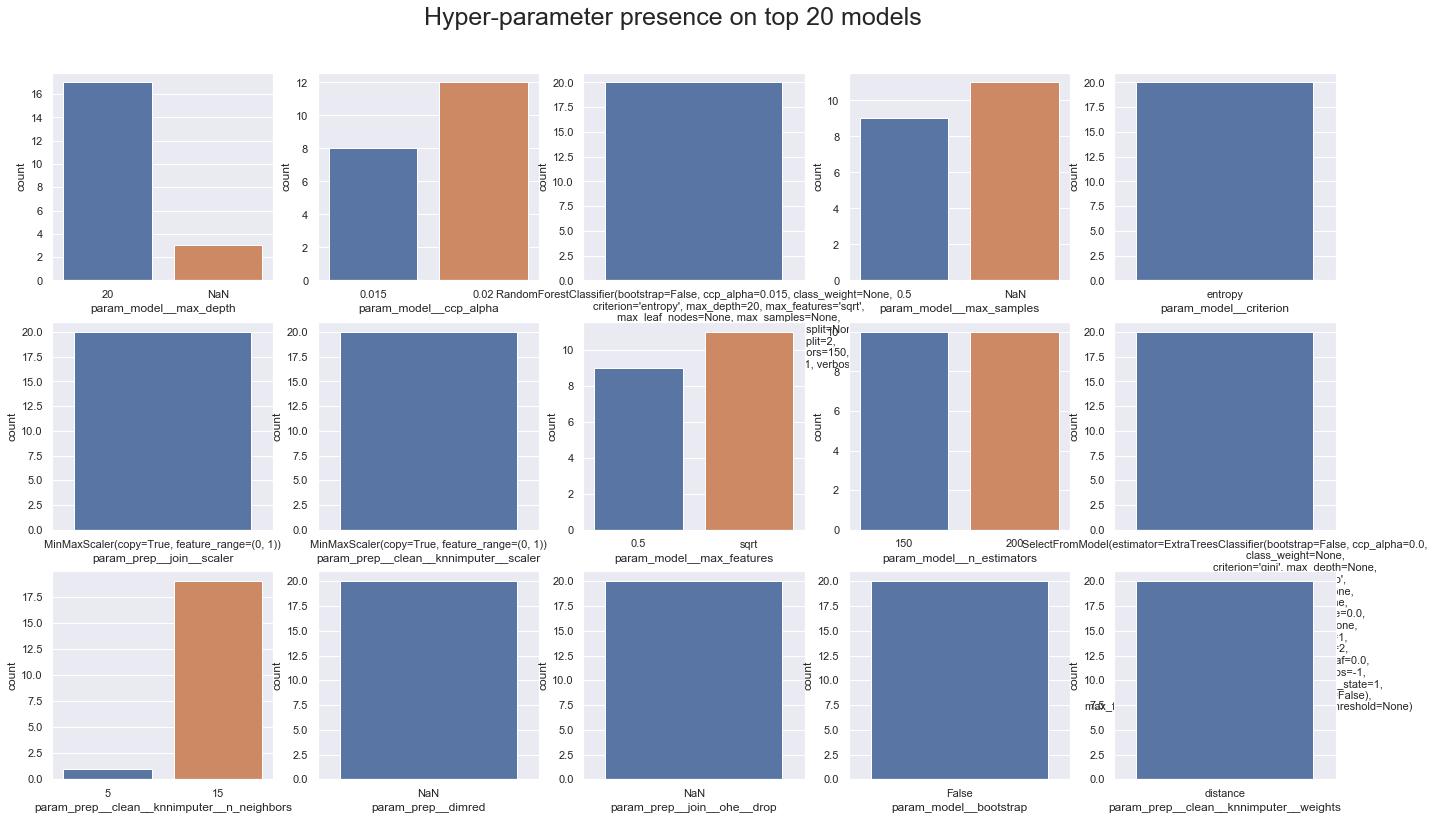

In [14]:
# Obtain outputs from Grid Search
gs_outputs(id_num, gscv, grid)  # if error occurs check ComplexEncoder 

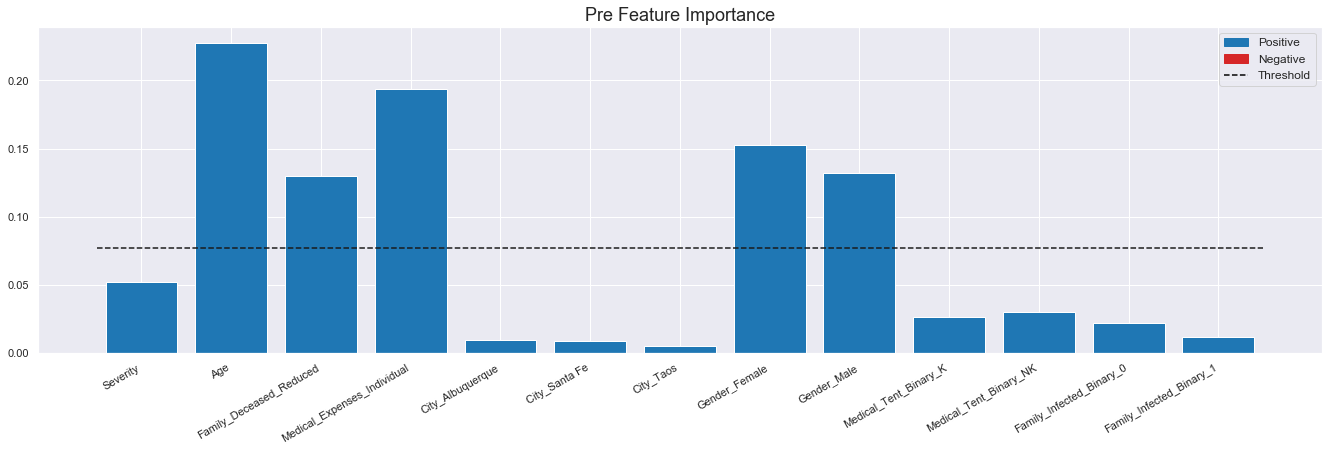

In [15]:
# Feature Importance pre
feature_importance(id_num, gscv, fimp_pre=True)

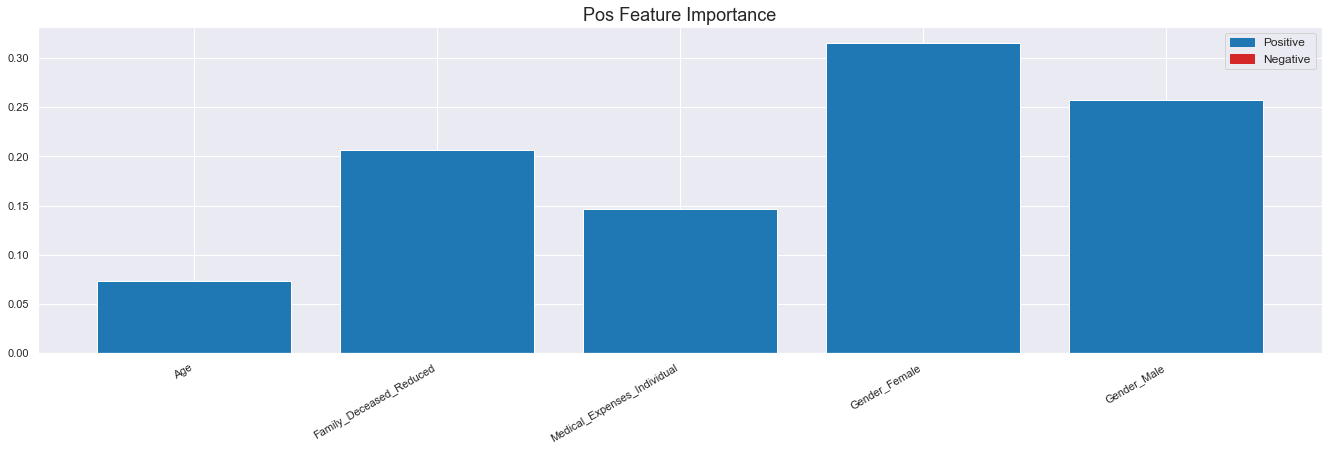

In [16]:
# Feature Importance pos
feature_importance(id_num, gscv, fimp_pre=False)

# References for running hyperparameter search on GCP
- https://cloud.google.com/ai-platform/training/docs/packaging-trainer  MISSING
- https://cloud.google.com/ai-platform/training/docs/working-with-cloud-storage  MISSING
- https://cloud.google.com/ai-platform/training/docs/python-client-library#cloud-shell
- https://cloud.google.com/ai-platform/training/docs/training-jobs#python
- https://cloud.google.com/ai-platform/training/docs/using-hyperparameter-tuning#python

In [10]:
#  Set authentication key to env variable: $env:GOOGLE_APPLICATION_CREDENTIALS="[PATH]"
# from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

In [ ]:
# TrainingInput - Represents input parameters for a training job
training_inputs = {
    'scaleTier': 'CUSTOM',
    'masterType': 'complex_model_m',
    'workerType': 'complex_model_m',
    'parameterServerType': 'large_model',
    'workerCount': 9,
    'parameterServerCount': 3,
    'packageUris': ['gs://my/trainer/path/package-0.0.0.tar.gz'],
    'pythonModule': 'trainer.task',
    'args': ['--arg1', 'value1', '--arg2', 'value2'],
    'region': 'us-central1',
    'jobDir': 'gs://my/training/job/directory',
    'runtimeVersion': '2.1',
    'pythonVersion': '3.7',
    'scheduling': {'maxRunningTime': '7200s'},
}

# HyperparameterSpec - Represents a set of hyperparameters to optimize
hyperparams = {
    'goal': 'MAXIMIZE',
    'hyperparameterMetricTag': 'metric1',
    'maxTrials': 30,
    'maxParallelTrials': 1,
    'enableTrialEarlyStopping': True,
    'params': []}

hyperparams['params'].append({
    'parameterName':'hidden1',
    'type':'INTEGER',
    'minValue': 40,
    'maxValue': 400,
    'scaleType': 'UNIT_LINEAR_SCALE'})

hyperparams['params'].append({
    'parameterName':'numRnnCells',
    'type':'DISCRETE',
    'discreteValues': [1, 2, 3, 4]})

hyperparams['params'].append({
    'parameterName':'rnnCellType',
    'type': 'CATEGORICAL',
    'categoricalValues': [
        'BasicLSTMCell',
        'BasicRNNCell',
        'GRUCell',
        'LSTMCell',
        'LayerNormBasicLSTMCell'
    ]
})

# Add hyperparameter specification to the training inputs dictionary
training_inputs['hyperparameters'] = hyperparams

# Build the JobSpec - Represents a training or prediction job
job_spec = {'jobId': my_job_name, 'trainingInput': training_inputs}

In [4]:
ml = discovery.build('ml','v1')  # Get your Python representation of the REST API.

In [ ]:
project_id = 'projects/{}'.format('molten-avatar-278709')  # Storing projectID

In [ ]:
request_dict = {'name': 'My First Project',
                'description': 'This is a machine learning model entry.'}  # Represents a machine learning solution

In [ ]:
# Making calls to APIs with the Python client library has two steps: first you create a request, then you make the call using that request
request = ml.projects().models().create(parent=project_id, body=request_dict)  # Form your request
# Send the request
try:  # use try block to catch possible errors
    response = request.execute()
    print(response)
except errors.HttpError, err:  # Add a catch block to handle HTTP errors
    print('There was an error creating the model. Check the details:')
    print(err._get_reason())